<a href="https://colab.research.google.com/github/jasminaaa20/MHealthActivityRecognition/blob/main/Assignment3_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Drive

In [ ]:
from google.colab import files, drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Create the combined dataframe using the dataset

In [ ]:
import pandas as pd

In [ ]:
comdf = pd.DataFrame()

In [ ]:
# Loop through and add all 10 subjects' sensor data to dataframe
for i in range(1, 11):
    df = pd.read_csv(f'/content/drive/MyDrive/datasets/MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    # Note: Excluding the ECG data collected with the chest sensor
    df = df.rename(columns= {
        0: 'acx',
        1: 'acy',
        2: 'acz',
        3: 'ecsig1',
        4: 'ecsig2',
        5: 'alx',
        6: 'aly',
        7: 'alz',
        8: 'glx',
        9: 'gly',
        10: 'glz',
        11: 'mlx',
        12: 'mly',
        13: 'mlz',
        14: 'arx',
        15: 'ary',
        16: 'arz',
        17: 'grx',
        18: 'gry',
        19: 'grz',
        20: 'mrx',
        21: 'mry',
        22: 'mrz',
        23: 'activity'
    })
    # introduce new column to differentiate between the subjects for creating the train-test split
    df['subject'] = f'subject{i}'
    comdf = pd.concat([comdf, df])

In [ ]:
comdf.shape

(1215745, 25)

### Additional adjustments to the dataset

In [ ]:
# Drop the rows where the subject is inactive
comdf = comdf[comdf['activity']!=0]
comdf.shape

(343195, 25)

In [ ]:
comdf.describe()

,acx,acy,acz,ecsig1,ecsig2,alx,aly,alz,glx,gly,...,arx,ary,arz,grx,gry,grz,mrx,mry,mrz,activity
count,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000,...,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000,343195.000000
mean,-7.485271,-0.140923,-0.938418,0.003649,-0.008048,1.805184,-9.061487,-0.701985,0.101167,-0.549942,...,-3.448201,-5.781446,2.381165,-0.201574,-0.410515,0.380693,-0.532629,1.422140,0.030670,6.169021
std,5.701949,2.799380,4.611164,0.839074,0.857724,4.214175,5.200389,6.457622,0.458913,0.434721,...,5.891595,6.578371,4.177971,0.549524,0.546359,0.515658,34.216257,30.285262,82.663004,3.298902
min,-22.438000,-20.188000,-18.401000,-8.619600,-8.619600,-22.146000,-19.619000,-19.373000,-1.779200,-2.660400,...,-22.345000,-18.972000,-18.238000,-1.170600,-2.256700,-1.114200,-319.030000,-358.130000,-702.570000,1.000000
25%,-9.707100,-1.294300,-3.686550,-0.213500,-0.171640,0.159875,-10.063000,-3.494350,-0.345080,-0.810510,...,-5.013900,-9.558100,0.139070,-0.682350,-0.831620,-0.040948,-6.228350,-7.272000,-12.170000,3.000000
50%,-8.800300,-0.292570,-0.881070,-0.071167,-0.046049,1.372500,-9.597700,0.340070,0.204080,-0.688560,...,-2.480000,-7.738900,1.819100,-0.300000,-0.597540,0.448280,0.360740,0.353930,-0.709300,6.000000
75%,-5.117400,0.984775,1.092650,0.163270,0.138150,2.924450,-7.549800,1.819300,0.487940,-0.487800,...,-0.539050,-2.359550,5.324750,0.278430,-0.045175,0.840520,5.224000,8.350250,10.302500,9.000000
max,19.094000,20.927000,26.196000,8.506500,8.519100,20.024000,21.161000,25.015000,1.710600,1.752300,...,19.801000,21.965000,25.741000,1.415700,1.121100,1.528000,239.690000,335.250000,657.180000,12.000000


In [ ]:
comdf['activity'].value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
7     29441
8     29337
6     28315
12    10342
Name: activity, dtype: int64

In [ ]:
# Convert the activity from range [1,12] to range [0,11] for indexing
comdf['activity'] = comdf['activity'] - 1

In [ ]:
comdf['activity'].unique()

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11,  4])

In [ ]:
comdf['subject'].value_counts()

subject2     35532
subject3     35380
subject4     35328
subject1     35174
subject9     34354
subject7     34253
subject5     33947
subject10    33690
subject8     33332
subject6     32205
Name: subject, dtype: int64

### Create the train-test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
trainx = pd.DataFrame()
trainy = pd.DataFrame()
testx = pd.DataFrame()
testy = pd.DataFrame()

In [ ]:
# For each activity within each test subject, take 70% of data for training and 30% of data for testing
for i in range(1,11):
  for activity in range(0,12):
    sub = comdf[(comdf['activity'] == activity) & (comdf['subject'] == 'subject'+str(i))]
    subx = sub.drop(['activity', 'subject'], axis=1)
    suby = sub['activity']
    subtrainx, subtestx, subtrainy, subtesty = train_test_split(subx,suby,test_size=0.3,random_state=3)
    trainx = pd.concat([trainx, subtrainx])
    trainy = pd.concat([trainy, subtrainy])
    testx = pd.concat([testx, subtestx])
    testy = pd.concat([testy, subtesty])

In [ ]:
print(trainx.shape)
print(trainy.shape)
print(testx.shape)
print(testy.shape)

(240182, 23)
(240182, 1)
(103013, 23)
(103013, 1)


### Standardize the train and test data

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
trainx_scaled = scaler.fit_transform(trainx)
testx_scaled = scaler.transform(testx)

In [ ]:
trainx.head(1)

,acx,acy,acz,ecsig1,ecsig2,alx,aly,alz,glx,gly,...,mlz,arx,ary,arz,grx,gry,grz,mrx,mry,mrz
8136,-9.871,0.61958,0.89787,-0.004186,-0.037677,2.4974,-9.5005,0.44578,-0.21707,-0.87805,...,-0.58665,-3.0288,-8.9639,1.6143,-0.070588,-0.93018,-0.3556,0.56029,2.1685,-0.37149


In [ ]:
trainx_scaled.shape

(240182, 23)

In [ ]:
trainx_scaled[0]

array([-4.19634023e-01,  2.71040698e-01,  3.99268186e-01, -9.49042352e-03,
       -3.42951976e-02,  1.65037174e-01, -8.35496150e-02,  1.77706611e-01,
       -6.92872148e-01, -7.55933725e-01, -6.80157716e-01, -6.96913110e-04,
        4.96967212e-02, -1.06417976e-02,  7.19747709e-02, -4.85388461e-01,
       -1.83587436e-01,  2.38116900e-01, -9.52483883e-01, -1.42626522e+00,
        3.08686024e-02,  2.45171784e-02, -5.24630760e-03])

### Models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

#### Model 1

In [ ]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

#### Model with dropout

In [ ]:
# class LSTMModelWithDropout(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTMModelWithDropout, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.dropout = nn.Dropout(0.25)  # Dropout layer with the specified dropout rate
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

#         # Apply dropout after each LSTM layer
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.dropout(out)  # Apply dropout after each LSTM layer
#         out = self.fc(out[:, -1, :])  # Take the last time step's output
#         return out

### Hyperparameters 1

In [ ]:
input_size = 23  # Number of features
hidden_size = 128  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
num_classes = 12  # Number of activity classes
batch_size = 64
learning_rate = 0.001
num_epochs = 10
sequence_length = 1

### Hyperparameters 2

In [ ]:
# # Hyperparameters
# input_size = 23  # Number of features
# hidden_size = 64  # Number of LSTM units
# num_layers = 3  # Number of LSTM layers
# num_classes = 12  # Number of activity classes
# batch_size = 64
# learning_rate = 0.001
# num_epochs = 10
# sequence_length = 1

### Training

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

In [ ]:
train_data = TensorDataset(torch.Tensor(trainx_scaled), torch.Tensor(trainy.values))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
n_total_steps = len(train_loader)

In [ ]:
dataset_shape = next(iter(train_loader))[0].shape
dataset_shape

torch.Size([64, 23])

In [ ]:
# Create the LSTM model
model = LSTMModelWithDropout(input_size, hidden_size, num_layers, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMModelWithDropout(
  (lstm): LSTM(23, 128, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=128, out_features=12, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
for epoch in range(num_epochs):
  for i, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.reshape(inputs.size()[0], sequence_length, input_size).to(device)
    labels = labels.view(-1).long().to(device)  # Ensure labels are of type torch.long

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if(i+1)%1000 == 0:
      print(f'Epoch[{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch[1/10], Step[1000/3753], Loss: 0.3810
Epoch[1/10], Step[2000/3753], Loss: 0.4314
Epoch[1/10], Step[3000/3753], Loss: 0.1272
Epoch[2/10], Step[1000/3753], Loss: 0.0909
Epoch[2/10], Step[2000/3753], Loss: 0.0952
Epoch[2/10], Step[3000/3753], Loss: 0.0465
Epoch[3/10], Step[1000/3753], Loss: 0.0942
Epoch[3/10], Step[2000/3753], Loss: 0.0759
Epoch[3/10], Step[3000/3753], Loss: 0.0489
Epoch[4/10], Step[1000/3753], Loss: 0.0532
Epoch[4/10], Step[2000/3753], Loss: 0.1597
Epoch[4/10], Step[3000/3753], Loss: 0.0222
Epoch[5/10], Step[1000/3753], Loss: 0.0320
Epoch[5/10], Step[2000/3753], Loss: 0.0571
Epoch[5/10], Step[3000/3753], Loss: 0.0223
Epoch[6/10], Step[1000/3753], Loss: 0.0084
Epoch[6/10], Step[2000/3753], Loss: 0.0163
Epoch[6/10], Step[3000/3753], Loss: 0.0224
Epoch[7/10], Step[1000/3753], Loss: 0.0286
Epoch[7/10], Step[2000/3753], Loss: 0.0100
Epoch[7/10], Step[3000/3753], Loss: 0.0088
Epoch[8/10], Step[1000/3753], Loss: 0.0010
Epoch[8/10], Step[2000/3753], Loss: 0.0003
Epoch[8/10]

### Evaluation

In [ ]:
from sklearn.metrics import (classification_report, accuracy_score,
                             recall_score, precision_score, f1_score,
                             confusion_matrix)

#### Evaluation 1

In [ ]:
# model.eval()
# with torch.no_grad():
#     test_inputs = torch.Tensor(testx_scaled).unsqueeze(1).to(device)
#     test_labels = torch.Tensor(testy.values).to(device).long()
#     test_outputs = model(test_inputs)
#     _, predicted = torch.max(test_outputs, 1)

# accuracy = accuracy_score(test_labels.cpu().numpy(), predicted.cpu().numpy())
# print(f'Test Accuracy: {accuracy * 100:.2f}%')  # Test Accuracy: 99.56%

#### Evaluation 2

In [ ]:
# model.eval()
# with torch.no_grad():
#     test_inputs = torch.Tensor(testx_scaled).unsqueeze(1).to(device)
#     test_labels = torch.Tensor(testy.values).to(device).long()
#     test_outputs = model(test_inputs)
#     _, predicted = torch.max(test_outputs, 1)

# accuracy = accuracy_score(test_labels.cpu().numpy(), predicted.cpu().numpy())
# print(f'Test Accuracy: {accuracy * 100:.2f}%')  # Test Accuracy: 99.33%

#### Evaluation 3

In [ ]:
model.eval()
with torch.no_grad():
    test_inputs = torch.Tensor(testx_scaled).unsqueeze(1).to(device)
    test_labels = torch.Tensor(testy.values).to(device).long()
    test_outputs = model(test_inputs)
    _, predicted = torch.max(test_outputs, 1)

accuracy = accuracy_score(test_labels.cpu().numpy(), predicted.cpu().numpy())
print(f'Test Accuracy: {accuracy * 100:.2f}%')  # Test Accuracy: 99.24%

Test Accuracy: 99.24%


### Training and Evaluation

In [ ]:
import numpy as np

# Initialize a list to store accuracy values
epoch_accuracies = []

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.reshape(inputs.size()[0], sequence_length, input_size).to(device)
        labels = labels.view(-1).long().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model after each epoch
    model.eval()
    with torch.no_grad():
        test_inputs = torch.Tensor(testx_scaled).unsqueeze(1).to(device)
        test_labels = torch.Tensor(testy.values).to(device).long()
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)

        accuracy = accuracy_score(test_labels.cpu().numpy(), predicted.cpu().numpy())
        epoch_accuracies.append(accuracy)

    model.train()  # Set the model back to training mode

    print(f'Epoch [{epoch+1}/{num_epochs}] - Test Accuracy: {accuracy * 100:.2f}%')

# Print the accuracy values after each epoch
print("Epoch Accuracies:", epoch_accuracies)

Epoch [1/10] - Test Accuracy: 99.58%
Epoch [2/10] - Test Accuracy: 99.66%
Epoch [3/10] - Test Accuracy: 99.58%
Epoch [4/10] - Test Accuracy: 99.64%
Epoch [5/10] - Test Accuracy: 99.61%
Epoch [6/10] - Test Accuracy: 99.62%
Epoch [7/10] - Test Accuracy: 99.65%
Epoch [8/10] - Test Accuracy: 99.63%
Epoch [9/10] - Test Accuracy: 99.63%
Epoch [10/10] - Test Accuracy: 99.65%
Epoch Accuracies: [0.9957675244872006, 0.9965926630619436, 0.9958451845883529, 0.996437342859639, 0.9961364099676739, 0.9962043625561823, 0.9964761729102152, 0.9962723151446905, 0.9962917301699785, 0.9965441254987235]


### Visualization

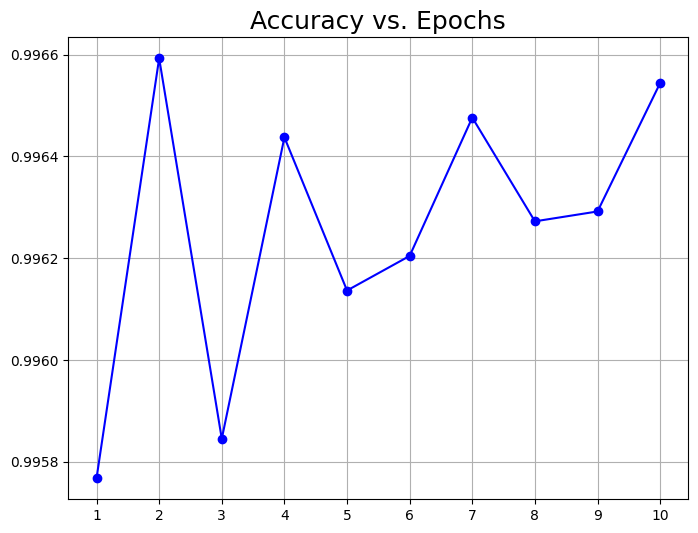

In [ ]:
import matplotlib.pyplot as plt

# Your code for training and storing accuracies here

# Plot the accuracies
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs. Epochs', fontsize=18)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(np.arange(1, num_epochs + 1))
plt.show()